### Dependencies & Prerequisites


In [1]:
from math import sin
from math import pi
import numpy as np
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot




import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
tfd = tfp.distributions
tfpl = tfp.layers
%matplotlib inline

### GPU Acceleration

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Dataset

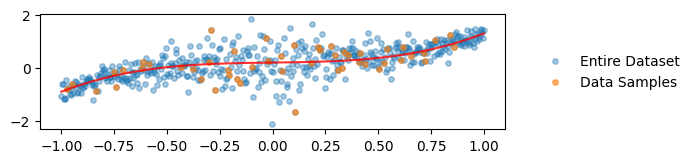

In [3]:
def load_dataset(n=500, ns=50):
  np.random.seed(44)
  x = np.linspace(-1, 1, n)
  y = np.power(x, 3) + 0.1 * (2 + x) + np.random.normal(0, (0.25/((np.abs(x)+0.25))), n)
  rnd_idx = np.random.choice(len(x), ns, replace=False)
  xs = x[rnd_idx]
  ys = y[rnd_idx]
  x = x[..., np.newaxis]
  xs = xs[..., np.newaxis]
  return x, y, xs, ys

x, y, xs, ys = load_dataset()

# Set figure size
plt.figure(figsize=(6, 1.5))
# Plot data
plt.plot(x, np.power(x, 3) + 0.1 * (2 + x), color='red', alpha=0.8)
plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4)
plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6)
# Add legend and show the plot
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

In [4]:
# expected improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat = model(X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	yhat_samples = model(Xsamples)
	mu = np.squeeze(yhat_samples.mean())
	std = np.squeeze(yhat_samples.stddev())
	# calculate the improvement
	improvement = np.asarray(mu - best)
	improvement=improvement.copy()
	improvement[improvement < 0] = 0  # no improvement if it's negative
	# calculate the expected improvement
	probs = norm.cdf(improvement / (std + 1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	#Xsamples = np.random.uniform(-1,1,100) # TODO: see why we need new samples here
	Xsamples = np.random.choice(X.reshape(len(X)), 100) # Get 100 random samples from X
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	idx = (np.abs(X - Xsamples[ix, 0])).argmin() # get closest index in available data
	x_new = X[idx]
	y_new = y[idx]
	return x_new, y_new

### BNN Model

In [5]:
# Define the negative log-likelihood function.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [6]:
# Define the variational posterior weight distribution -- Multivariate Gaussian.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [7]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

In [8]:
# Build model.
model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0]),
    tfpl.IndependentNormal(1)
])

# Compile model.
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.005), loss=negloglik)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [9]:
def fit_model(iter, model, xs, ys, epochs=1000, verbose=False):
    # Fit model.
    model.fit(xs, ys, epochs=epochs, verbose=verbose);

    # Model predictions with uncertainty.
    yhat = model(x);
    mu = np.squeeze(yhat.mean());
    sigma = np.squeeze(yhat.stddev());

    # Evaluate acquisition function.
    plt.figure(figsize=[6, 1.5]); # inches
    plt.clf();
    plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4);
    plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6);
    plt.scatter(x, yhat.sample(), s=15, label="Model Predictions", alpha=0.4);
    plt.plot(x, mu, 'r', label='$\mu$', linewidth=1, alpha=1);
    data = x.copy()
    plt.fill_between(data.reshape(data.shape[0]), mu-2*sigma, mu+2*sigma, color='lawngreen', label='$\mu\pm2\sigma$', alpha=0.3);
    if iter !=0:
        plt.scatter(xs[-1], ys[-1], s=30, marker='*', color='m', label="New Sample", alpha=1.0);
    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom');
    ax.yaxis.set_ticks_position('left');
    ax.spines['left'].set_position(('data', 0));
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));
    plt.title("Iteration {}".format(iter+1))

    return mu, sigma;

### Active Sampling

New Sample (x, y): (0.41482965931863713, 0.5552131048452288)
New Sample (x, y): (0.3106212424849699, -0.08352608840350373)
New Sample (x, y): (0.22645290581162314, 0.6789515562343591)
New Sample (x, y): (0.41482965931863713, 0.5552131048452288)
New Sample (x, y): (-0.1823647294589179, 0.620090765817087)
New Sample (x, y): (-0.9719438877755511, -0.7974456009007981)
New Sample (x, y): (0.2945891783567134, 0.4775664133342634)
New Sample (x, y): (-0.1823647294589179, 0.620090765817087)
New Sample (x, y): (-0.09819639278557124, 0.0491347526370389)
New Sample (x, y): (-0.33867735470941884, -0.4149293310660789)
New Sample (x, y): (0.2945891783567134, 0.4775664133342634)
New Sample (x, y): (0.41482965931863713, 0.5552131048452288)
New Sample (x, y): (0.5430861723446891, 0.7110724685715197)
New Sample (x, y): (-0.1823647294589179, 0.620090765817087)
New Sample (x, y): (0.04208416833667328, 0.44629015697887703)
New Sample (x, y): (0.3106212424849699, -0.08352608840350373)
New Sample (x, y): (-0.

C:\Users\tsamak\AppData\Local\Temp\ipykernel_39648\333152828.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[6, 1.5]); # inches


New Sample (x, y): (0.5430861723446891, 0.7110724685715197)
New Sample (x, y): (-0.37474949899799603, -0.04842585764495834)
New Sample (x, y): (0.21442885771543074, 0.799053588365493)
New Sample (x, y): (-0.434869739478958, 0.024342266571953278)
New Sample (x, y): (0.2745490981963927, 0.8373758728307095)
New Sample (x, y): (0.04208416833667328, 0.44629015697887703)
New Sample (x, y): (-0.9719438877755511, -0.7974456009007981)
New Sample (x, y): (-0.33867735470941884, -0.4149293310660789)
New Sample (x, y): (-0.030060120240480992, 1.1254841140635126)
New Sample (x, y): (-0.30260521042084176, 0.23916623344508725)
New Sample (x, y): (-0.30260521042084176, 0.23916623344508725)
New Sample (x, y): (0.41482965931863713, 0.5552131048452288)
New Sample (x, y): (0.6072144288577153, 0.31108475600047397)
New Sample (x, y): (-0.16633266533066138, -0.4060058267505532)
New Sample (x, y): (0.41482965931863713, 0.5552131048452288)
New Sample (x, y): (0.503006012024048, -0.024193580561669537)
New Sample

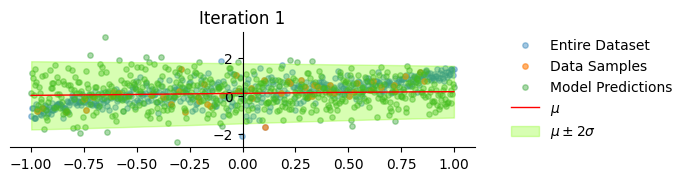

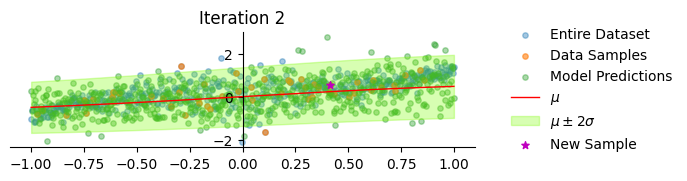

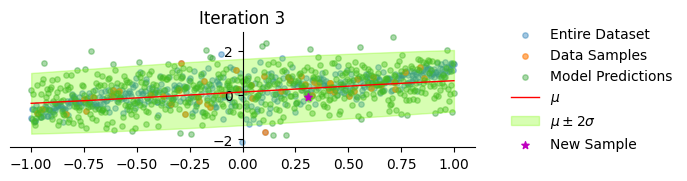

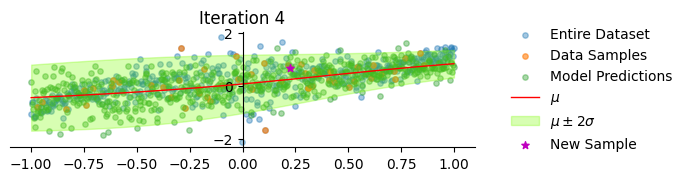

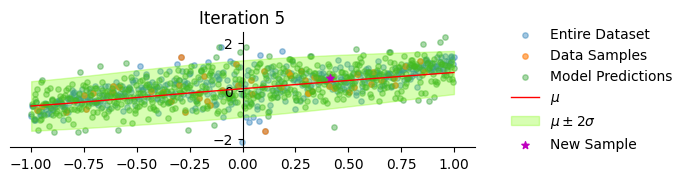

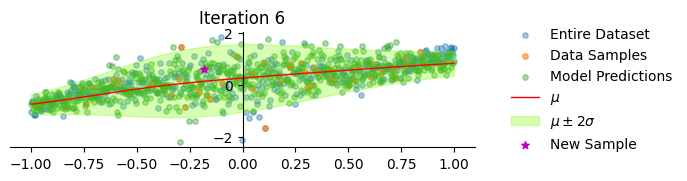

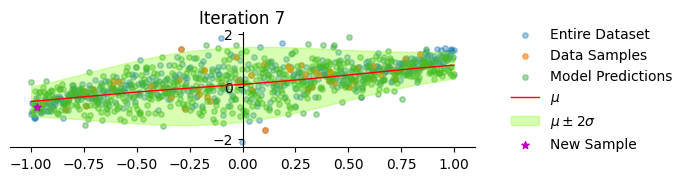

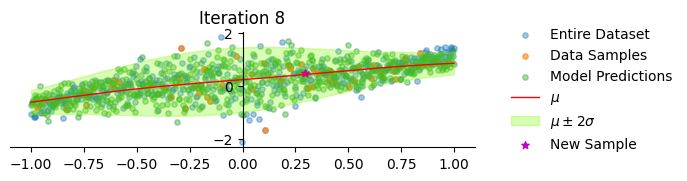

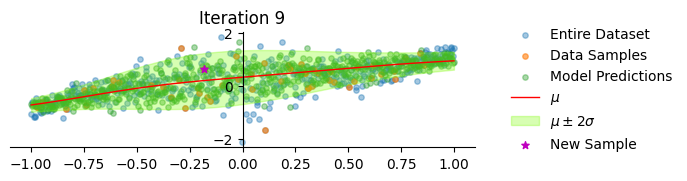

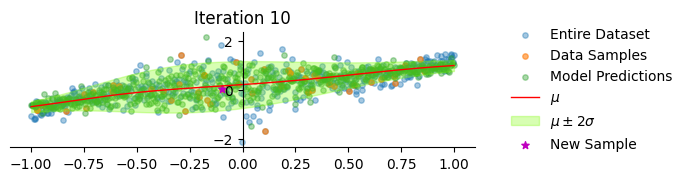

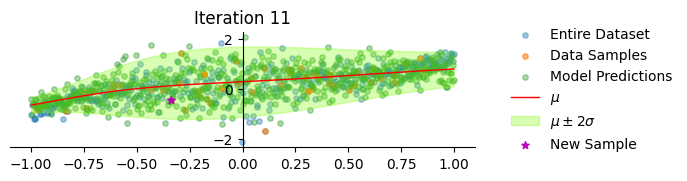

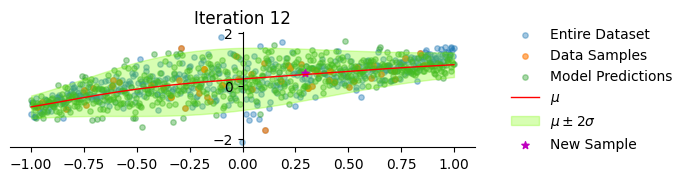

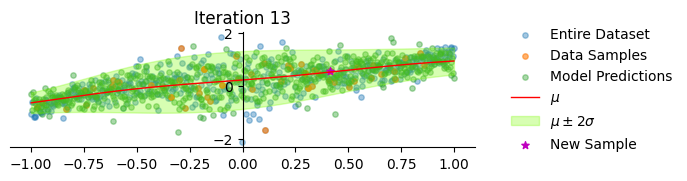

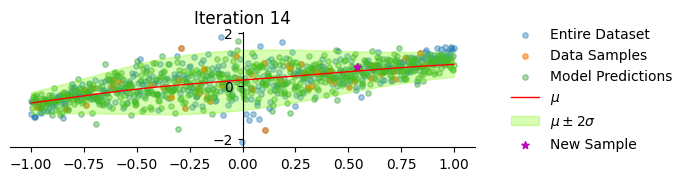

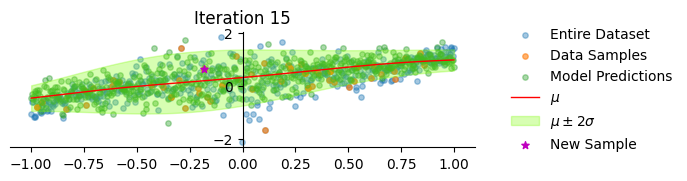

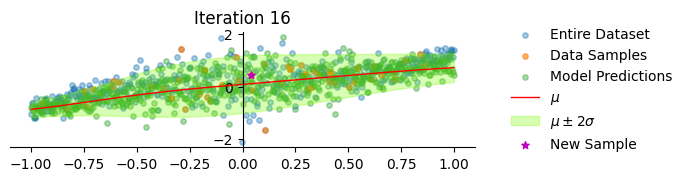

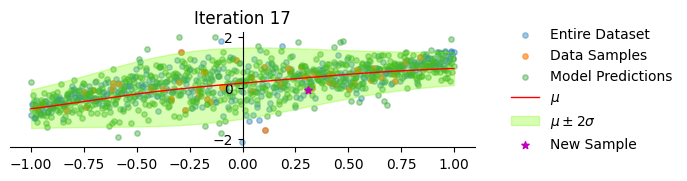

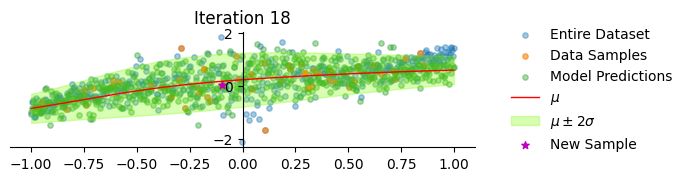

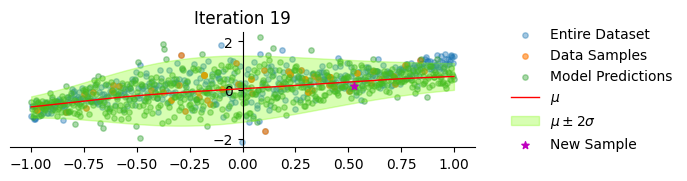

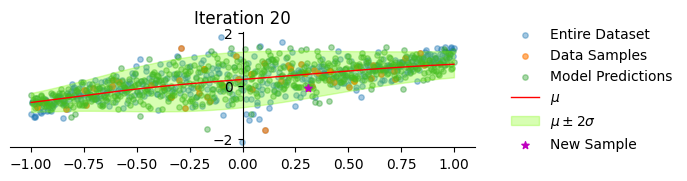

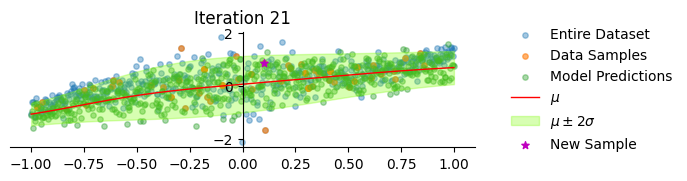

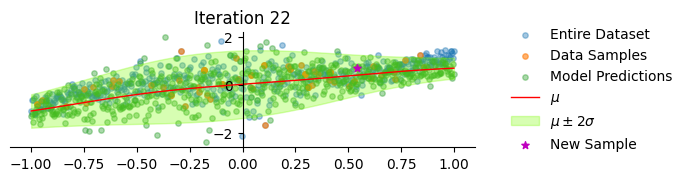

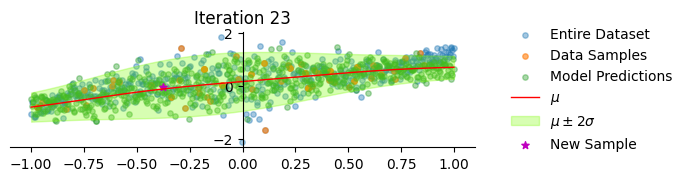

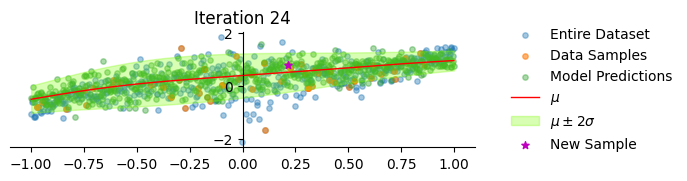

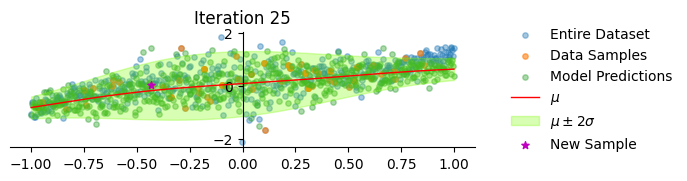

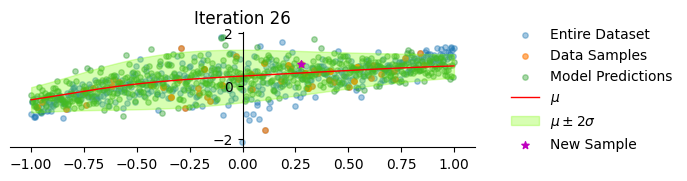

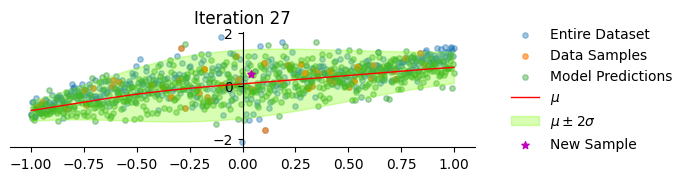

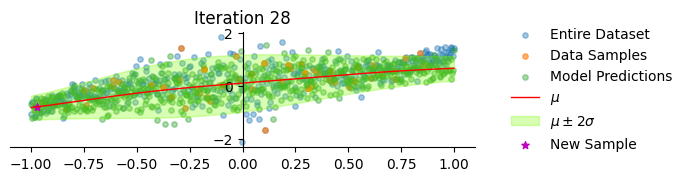

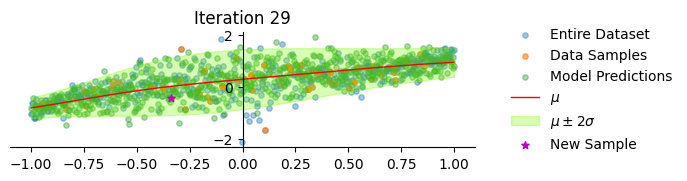

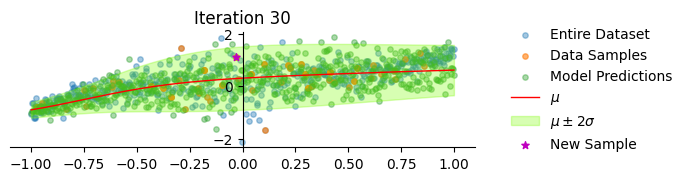

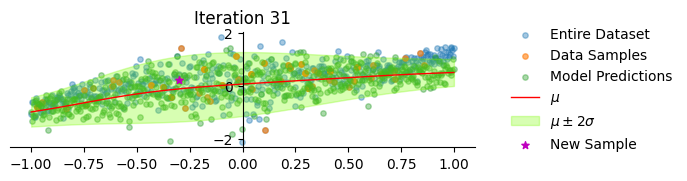

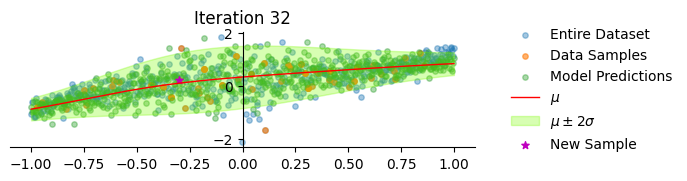

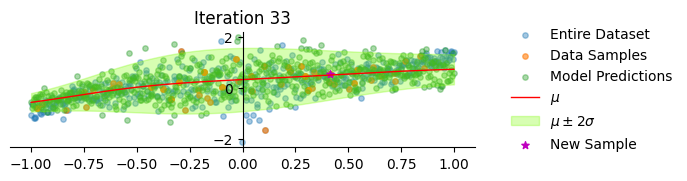

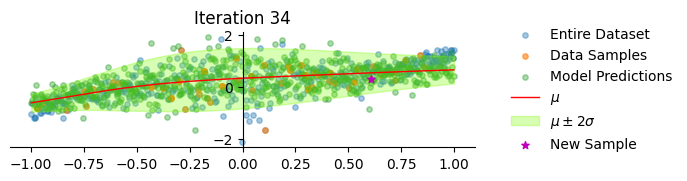

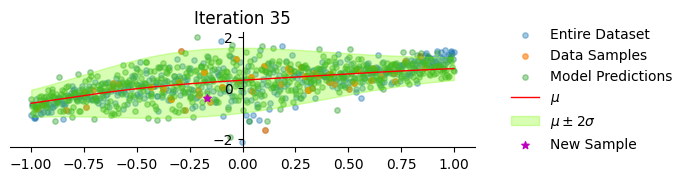

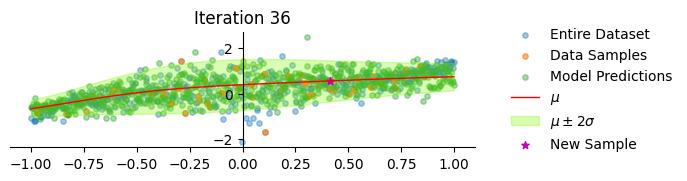

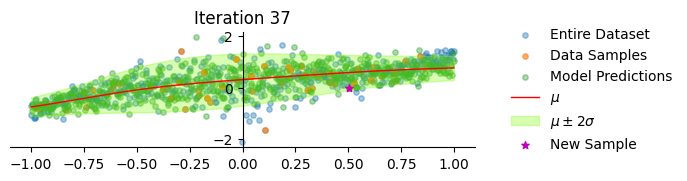

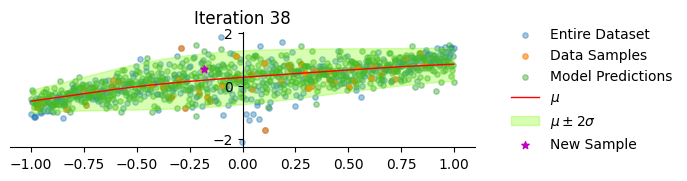

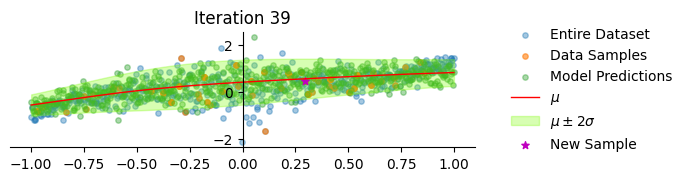

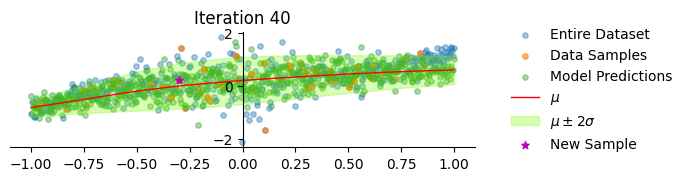

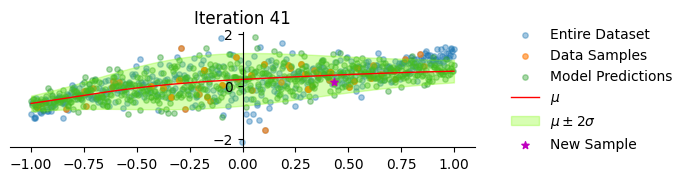

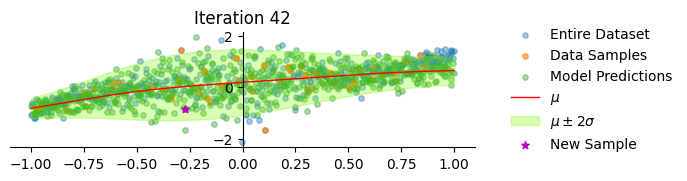

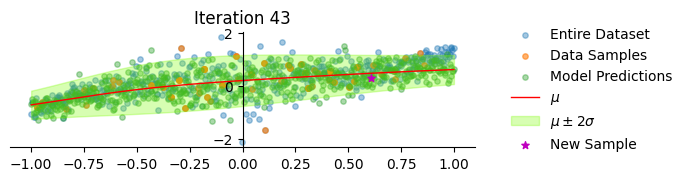

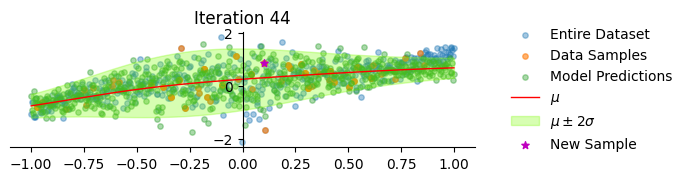

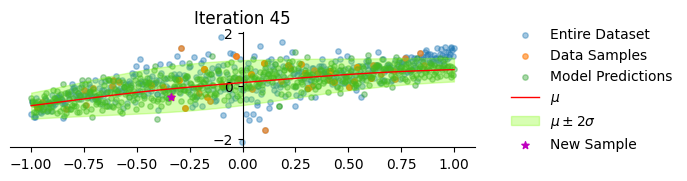

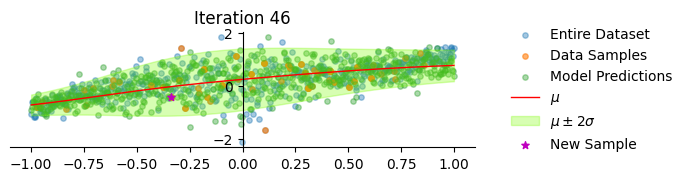

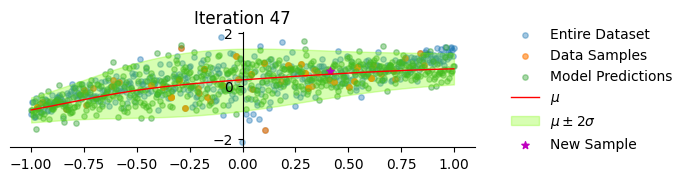

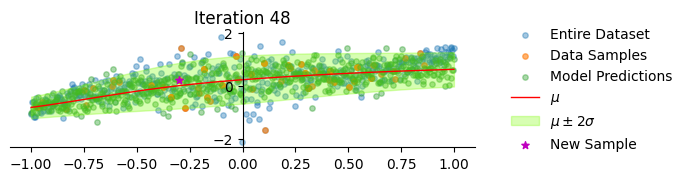

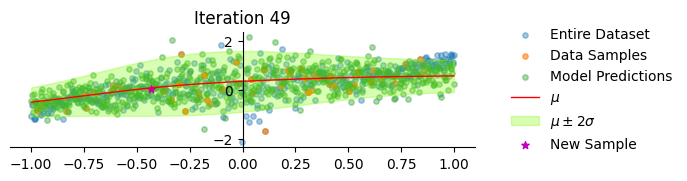

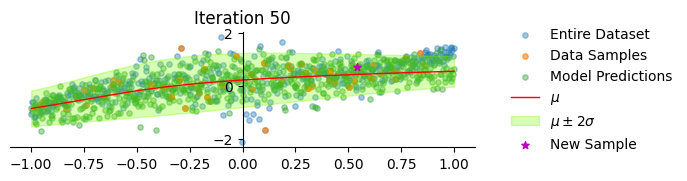

In [10]:
for i in range(50):
    # Train BNN model and visualize predictions
    mu, sigma = fit_model(i, model, xs, ys, epochs=1000, verbose=False);

    # Active sampling
    x_new, y_new = opt_acquisition(xs, ys, model)
    xs = np.append(xs, x_new).reshape(xs.shape[0]+1,1); # Add next sample to XS and reshape the resulting flattened array
    ys = np.append(ys, y_new); # Add next sample to YS
    print("New Sample (x, y): ({}, {})".format(xs[-1][0], ys[-1]))